## Import Libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install allennlp-models

In [ ]:
!rm seq2seq_trainer.py
!rm seq2seq_training_args.py
!wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_trainer.py
!wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_training_args.py

In [ ]:
# system packages
import os
import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

# TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

# Transformer
from transformers import AutoTokenizer, DefaultDataCollator, EncoderDecoderModel
from seq2seq_trainer import Seq2SeqTrainer
from seq2seq_training_args import Seq2SeqTrainingArguments

# Dataset
from datasets import Dataset, load_metric
import datasets

import matplotlib.pyplot as plt

import json

import random

import torch

from tqdm.auto import tqdm
import collections

from allennlp_models.rc.tools import squad

from copy import deepcopy

## Environment Settings

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  torch.manual_seed(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

set_reproducibility(42)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

## Dataset utils

Definition of `qa_type` function. It classifies the question and the answers in 5 types, according to the CoQA dataset paper: ["CoQA: A Conversational Question Answering Challenge"](https://arxiv.org/abs/1808.07042).

We classified an answer as "count" if the corresponding question contains "how many", as "no" or "yes" if the answer contains respectively "no" and "yes", as "multiple" if the corresponding question contains "or", while as "fluent" for all the other cases.

In [ ]:
import re

def qa_type(q, a):
  if re.search(r"^\byes\b", a.strip().lower()):
    return "yes"
  if re.search(r"^\bno\b", a.strip().lower()):
    return "no"
  if re.search(r"\bhow many\b", q.strip().lower()):
    return "count"
  if re.search(r"\bor\b", q.strip().lower()):
    return "multiple"
  return "fluent"

Dataset rearrangement: a dataframe is built in order to handle the data in an easier way. 

For each QA pair, some useful information is kept such as the `conv_id`, `q_id`, `source` and the `qa_type` which are the conversation id, the question id, the source of the QA pair and the question type, respectively.

In [ ]:
def build_dataframe(data):
  rows = []
  for i in range(len(data)): # iteration over the conversations
    for j in range(len(data[i]["questions"])): # iteration over the questions
      if data[i]["answers"][j]["input_text"] != "unknown": # if a question does not have an answer, we skip it
        rows.append([
            data[i]["id"],
            data[i]["questions"][j]["turn_id"],
            data[i]["story"].strip().lower(),
            data[i]["questions"][j]["input_text"].strip().lower(),
            data[i]["answers"][j]["input_text"].strip().lower(),
            data[i]["source"],
            qa_type(data[i]["questions"][j]["input_text"], data[i]["answers"][j]["input_text"])
        ])

  return pd.DataFrame(rows, columns = ["conv_id", "q_id", "story", "question", "answer", "source", "qa_type"])

Creation of the dataset to handle the history of the conversation. The `story` feature is the concatenation of the story and the past question-answer pairs.

In [ ]:
def build_history_dataframe(data):
  rows = []
  for i in range(len(data)): # iteration over the conversations
    story = ""
    last_q = ""
    last_a = ""
    for j in range(len(data[i]["questions"])): # iteration over the questions
      if data[i]["answers"][j]["input_text"] != "unknown": # if a question does not have an answer, we skip it
        question = data[i]["questions"][j]["input_text"].lower()
        answer = data[i]["answers"][j]["input_text"].lower()
        if len(story) == 0:
          story = data[i]["story"].lower()
        else:
          story += " [SEP] " + last_q + " [SEP] " + last_a
        rows.append([
            data[i]["id"],
            data[i]["questions"][j]["turn_id"],
            story,
            question,
            answer,
            data[i]["source"],
            qa_type(question, answer)
        ])
        last_q = question
        last_a = answer

  return pd.DataFrame(rows, columns = ["conv_id", "q_id", "story", "question", "answer", "source", "qa_type"])

## Dataset Download

In [ ]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')

coqa-train-v1.0.json: 49.0MB [00:05, 8.75MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:00, 10.1MB/s]                            

Download completed!


###### Dataset Inspection

In [ ]:
with open("coqa/train.json") as f:
  train = json.load(f)

with open("coqa/test.json") as f:
  test = json.load(f)

In [ ]:
print(train.keys())
print("Dataset version:", train["version"])
train = train["data"]
test = test["data"]

dict_keys(['version', 'data'])
Dataset version: 1.0


In [ ]:
print(json.dumps(train[0], indent=4))

{
    "source": "wikipedia",
    "id": "3zotghdk5ibi9cex97fepx7jetpso7",
    "filename": "Vatican_Library.txt",
    "story": "The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. \n\nThe Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. \n\nIn March 2014, the Vatican Library began an initial four-year project of digitising its collection of ma

In [ ]:
print("Training Set")
print("Number of conversations: ", len(train))

print("\nTest Set")
print("Number of conversations: ", len(test))

Training Set
Number of conversations:  7199

Test Set
Number of conversations:  500


###### Train-Validation split

The dataset is randomly shuffled before being split into train and validation splits. Since the dataset is grouped by the conversation (i.e. each element of the train list is a conversation), we are sure that each dialogue appears in one split only.

In [ ]:
random.shuffle(train)
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

## Model definition and data tokenization

In [ ]:
def create_model(model_name):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name)

  # set the parameters for the generation phase
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  model.config_eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  model.config.vocab_size = model.config.encoder.vocab_size
  model.config.max_length = 10
  model.config.min_length = 1
  model.config.no_repeat_ngram_size = 3
  model.config.early_stopping = True
  model.config.length_penalty = 3.0
  model.config.num_beams = 8

  return model, tokenizer

In [ ]:
def create_trainer(model, train_data, val_data):
  training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    gradient_accumulation_steps=1,
    optim="adafactor",
    save_steps=1000,
    save_total_limit=1,
    warmup_steps=1000,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=500,
    fp16=True
  )
  trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
  )
  return trainer

The `tokenize_dataset` function takes a batch of rows of the Dataset object and computes the tokenization and then returns it.

In [ ]:
def tokenize_dataset(batch, tokenizer):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["question"], batch["story"], padding="max_length", truncation="only_second", max_length=512) 
  outputs = tokenizer(batch["answer"], padding="max_length", truncation=True, max_length=10)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `labels`. 
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

## Generation and Evaluation

The `generate_evaluate` function takes as input a batch of the Dataset object, the tokenizer, model and a model alias. It generates the predictions for the elements in the batch and computes the metric. At the end it adds the computed results to the dataset by using the `model_name` to index the new information.

In [ ]:
def generate_evaluate(batch, tokenizer, model, model_name):
    # cut off at BERT max length 512
    inputs = tokenizer(batch["question"], batch["story"], padding="max_length", truncation="only_second", max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    # answer generation
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # add results to the dataset
    batch[f"gen_{model_name}"] = output_str
    f1_metrics =  [squad.compute_f1(p, batch["answer"][i]) for i, p in enumerate(batch[f"gen_{model_name}"])]
    batch[f"f1_{model_name}"] = f1_metrics

    return batch

The `generate` function takes as input a story, a question, a model and a tokenizer. The story could also contain the history of the conversation. The function returns the generated answer.

In [ ]:
def generate(story, question, model, tokenizer):
  inputs = tokenizer(question, story, padding="max_length", truncation="only_second", max_length=512, return_tensors="pt")
  input_ids = inputs.input_ids.to("cuda")
  attention_mask = inputs.attention_mask.to("cuda")
  outputs = model.generate(input_ids, attention_mask=attention_mask)
  return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

## Create the dataset

In [ ]:
df_train = build_dataframe(train)
df_validation = build_dataframe(validation)
df_test = build_dataframe(test)

In [ ]:
train_dataset = Dataset.from_dict(df_train)
validation_dataset = Dataset.from_dict(df_validation)
test_dataset = Dataset.from_dict(df_test)

In [ ]:
df_train.head(20)

,conv_id,q_id,story,question,answer,source,qa_type
0,3vnl7uk1xfjpizejz41ec8urozstf3,1,bbc television is a service of the british bro...,when was britain's first television broadcast?,2 november 1936.,wikipedia,fluent
1,3vnl7uk1xfjpizejz41ec8urozstf3,2,bbc television is a service of the british bro...,when was the bbc founded?,1927,wikipedia,fluent
2,3vnl7uk1xfjpizejz41ec8urozstf3,3,bbc television is a service of the british bro...,how are their shows funded?,by a television licence.,wikipedia,fluent
3,3vnl7uk1xfjpizejz41ec8urozstf3,4,bbc television is a service of the british bro...,where is baird television ltd broadcasted from?,from its studio,wikipedia,fluent
4,3vnl7uk1xfjpizejz41ec8urozstf3,5,bbc television is a service of the british bro...,where is the studio located?,in long acre,wikipedia,fluent
5,3vnl7uk1xfjpizejz41ec8urozstf3,6,bbc television is a service of the british bro...,when did they stop stop broadcasting through t...,until june 1932,wikipedia,fluent
6,3vnl7uk1xfjpizejz41ec8urozstf3,7,bbc television is a service of the british bro...,is there a major difference between television...,there is little distinction,wikipedia,fluent
7,3vnl7uk1xfjpizejz41ec8urozstf3,8,bbc television is a service of the british bro...,when did they start using sound and picture?,on 30 march 1930,wikipedia,fluent
8,3vnl7uk1xfjpizejz41ec8urozstf3,9,bbc television is a service of the british bro...,which days of the week broadcasted midnight pr...,tuesdays and fridays,wikipedia,fluent
9,3vnl7uk1xfjpizejz41ec8urozstf3,10,bbc television is a service of the british bro...,where was the transmitter located?,brookmans park,wikipedia,fluent


## Set Seed for train/evaluation

In [ ]:
set_reproducibility(1337)

## QA Without Conversation History

### Model BERTTiny

In [ ]:
model_name = "prajjwal1/bert-tiny"
berttiny_model, berttiny_tokenizer = create_model(model_name)

###### Data tokenization

In [ ]:
batch_size=16

train_data = train_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=train_dataset.column_names,
    fn_kwargs = {"tokenizer": berttiny_tokenizer}
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)
val_data = validation_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=validation_dataset.column_names,
    fn_kwargs = {"tokenizer": berttiny_tokenizer}
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

  0%|          | 0/5371 [00:00<?, ?ba/s]

  0%|          | 0/1334 [00:00<?, ?ba/s]

###### Training

In [ ]:
berttiny_trainer = create_trainer(berttiny_model, train_data, val_data)

In [ ]:
berttiny_trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85932
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16113
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on

Epoch,Training Loss,Validation Loss
1,3.795800,3.577923
2,3.513400,3.464657
3,3.444700,3.436625


Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-16000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting olde

TrainOutput(global_step=16113, training_loss=3.853499774344546, metrics={'train_runtime': 2103.3996, 'train_samples_per_second': 122.562, 'train_steps_per_second': 7.66, 'total_flos': 784037738373120.0, 'train_loss': 3.853499774344546, 'epoch': 3.0})

###### Model evaluation

In [ ]:
validation_dataset = validation_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": berttiny_tokenizer, 
    "model": berttiny_model, 
    "model_name": "no_his_berttiny"
  }
)
test_dataset = test_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": berttiny_tokenizer, 
    "model": berttiny_model, 
    "model_name": "no_his_berttiny"
  }
)

  0%|          | 0/1334 [00:00<?, ?ba/s]

  0%|          | 0/495 [00:00<?, ?ba/s]

In [ ]:
f1_valid_berttiny = sum(validation_dataset["f1_no_his_berttiny"])/len(validation_dataset["f1_no_his_berttiny"])
print("Bert-tiny without history F1_valid =", round(f1_valid_berttiny, 4))

Bert-tiny without history F1_valid = 0.1224


In [ ]:
f1_berttiny = sum(test_dataset["f1_no_his_berttiny"])/len(test_dataset["f1_no_his_berttiny"])
print("Bert-tiny without history F1_test =", round(f1_berttiny, 4))

Bert-tiny without history F1_test = 0.1258


### Model DistilRoBERTa

In [ ]:
model_name = "distilroberta-base"
roberta_model, roberta_tokenizer = create_model(model_name)

###### Data tokenization

In [ ]:
batch_size=16

train_data = train_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=train_dataset.column_names,
    fn_kwargs = {"tokenizer": roberta_tokenizer}
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)
val_data = validation_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=validation_dataset.column_names,
    fn_kwargs = {"tokenizer": roberta_tokenizer}
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

  0%|          | 0/5371 [00:00<?, ?ba/s]

  0%|          | 0/1334 [00:00<?, ?ba/s]

###### Training

In [ ]:
roberta_trainer = create_trainer(roberta_model, train_data, val_data)

In [ ]:
roberta_trainer.train()

###### Model evaluation

In [ ]:
validation_dataset = validation_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": roberta_tokenizer, 
    "model": roberta_model, 
    "model_name": "no_his_roberta"
  }
)
test_dataset = test_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": roberta_tokenizer, 
    "model": roberta_model, 
    "model_name": "no_his_roberta"
  }
)

  0%|          | 0/1334 [00:00<?, ?ba/s]

  0%|          | 0/495 [00:00<?, ?ba/s]

In [ ]:
f1_valid_roberta = sum(validation_dataset["f1_no_his_roberta"])/len(validation_dataset["f1_no_his_roberta"])
print("Roberta without history F1_valid =", round(f1_valid_roberta, 4))

Roberta without history F1_valid = 0.3826


In [ ]:
f1_roberta =sum(test_dataset["f1_no_his_roberta"])/len(test_dataset["f1_no_his_roberta"])
print("Roberta without history F1_test =", round(f1_roberta, 4))

Roberta without history F1_test = 0.3892


## Conversational QA

### Create the dataset

In [ ]:
his_df_train = build_history_dataframe(train)
his_df_validation = build_history_dataframe(validation)
his_df_test = build_history_dataframe(test)

In [ ]:
his_train_dataset = Dataset.from_dict(his_df_train)
his_validation_dataset = Dataset.from_dict(his_df_validation)
his_test_dataset = Dataset.from_dict(his_df_test)

In [ ]:
his_df_train.head(20)

,conv_id,q_id,story,question,answer,source,qa_type
0,3vnl7uk1xfjpizejz41ec8urozstf3,1,bbc television is a service of the british bro...,when was britain's first television broadcast?,2 november 1936.,wikipedia,fluent
1,3vnl7uk1xfjpizejz41ec8urozstf3,2,bbc television is a service of the british bro...,when was the bbc founded?,1927,wikipedia,fluent
2,3vnl7uk1xfjpizejz41ec8urozstf3,3,bbc television is a service of the british bro...,how are their shows funded?,by a television licence.,wikipedia,fluent
3,3vnl7uk1xfjpizejz41ec8urozstf3,4,bbc television is a service of the british bro...,where is baird television ltd broadcasted from?,from its studio,wikipedia,fluent
4,3vnl7uk1xfjpizejz41ec8urozstf3,5,bbc television is a service of the british bro...,where is the studio located?,in long acre,wikipedia,fluent
5,3vnl7uk1xfjpizejz41ec8urozstf3,6,bbc television is a service of the british bro...,when did they stop stop broadcasting through t...,until june 1932,wikipedia,fluent
6,3vnl7uk1xfjpizejz41ec8urozstf3,7,bbc television is a service of the british bro...,is there a major difference between television...,there is little distinction,wikipedia,fluent
7,3vnl7uk1xfjpizejz41ec8urozstf3,8,bbc television is a service of the british bro...,when did they start using sound and picture?,on 30 march 1930,wikipedia,fluent
8,3vnl7uk1xfjpizejz41ec8urozstf3,9,bbc television is a service of the british bro...,which days of the week broadcasted midnight pr...,tuesdays and fridays,wikipedia,fluent
9,3vnl7uk1xfjpizejz41ec8urozstf3,10,bbc television is a service of the british bro...,where was the transmitter located?,brookmans park,wikipedia,fluent


### Model BERTTiny

In [ ]:
model_name = "prajjwal1/bert-tiny"
his_berttiny_model, his_berttiny_tokenizer = create_model(model_name)

###### Data tokenization

In [ ]:
batch_size=16

train_data = his_train_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=his_train_dataset.column_names,
    fn_kwargs = {"tokenizer": his_berttiny_tokenizer}
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)
val_data = his_validation_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=his_validation_dataset.column_names,
    fn_kwargs = {"tokenizer": his_berttiny_tokenizer}
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

  0%|          | 0/5371 [00:00<?, ?ba/s]

  0%|          | 0/1334 [00:00<?, ?ba/s]

###### Training

In [ ]:
his_berttiny_trainer = create_trainer(his_berttiny_model, train_data, val_data)

In [ ]:
his_berttiny_trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85932
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16113
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on

Epoch,Training Loss,Validation Loss
1,3.877800,3.636300
2,3.532500,3.481627
3,3.461300,3.451904


Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-16000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting olde

TrainOutput(global_step=16113, training_loss=3.876853053177534, metrics={'train_runtime': 2078.0514, 'train_samples_per_second': 124.057, 'train_steps_per_second': 7.754, 'total_flos': 784037738373120.0, 'train_loss': 3.876853053177534, 'epoch': 3.0})

###### Model evaluation

In [ ]:
his_validation_dataset = his_validation_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": his_berttiny_tokenizer, 
    "model": his_berttiny_model, 
    "model_name": "his_berttiny"
  }
)
his_test_dataset = his_test_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": his_berttiny_tokenizer, 
    "model": his_berttiny_model, 
    "model_name": "his_berttiny"
  }
)

  0%|          | 0/1334 [00:00<?, ?ba/s]

  0%|          | 0/495 [00:00<?, ?ba/s]

In [ ]:
his_f1_valid_berttiny = sum(his_validation_dataset["f1_his_berttiny"])/len(his_validation_dataset["f1_his_berttiny"])
print("Bert-tiny without history F1_valid =", round(his_f1_valid_berttiny, 4))

Bert-tiny without history F1_valid = 0.1213


In [ ]:
his_f1_berttiny =sum(his_test_dataset["f1_his_berttiny"])/len(his_test_dataset["f1_his_berttiny"])
print("Bert-tiny without history F1_test =", round(his_f1_berttiny, 4))

Bert-tiny without history F1_test = 0.125


### Model DistilRoBERTa

In [ ]:
model_name = "distilroberta-base"
his_roberta_model, his_roberta_tokenizer = create_model(model_name)

###### Data tokenization

In [ ]:
batch_size=16

train_data = his_train_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=his_train_dataset.column_names,
    fn_kwargs = {"tokenizer": his_roberta_tokenizer}
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)
val_data = his_validation_dataset.map(
    tokenize_dataset, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=his_validation_dataset.column_names,
    fn_kwargs = {"tokenizer": his_roberta_tokenizer}
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

  0%|          | 0/5371 [00:00<?, ?ba/s]

  0%|          | 0/1334 [00:00<?, ?ba/s]

###### Training

In [ ]:
his_roberta_trainer = create_trainer(his_roberta_model, train_data, val_data)

In [ ]:
his_roberta_trainer.train()

###### Model evaluation

In [ ]:
his_validation_dataset = his_validation_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": his_roberta_tokenizer, 
    "model": his_roberta_model, 
    "model_name": "his_roberta"
  }
)
his_test_dataset = his_test_dataset.map(
  generate_evaluate, 
  batched=True, 
  batch_size=batch_size, 
  fn_kwargs = {
    "tokenizer": his_roberta_tokenizer, 
    "model": his_roberta_model, 
    "model_name": "his_roberta"
  }
)

  0%|          | 0/1334 [00:00<?, ?ba/s]

  0%|          | 0/495 [00:00<?, ?ba/s]

In [ ]:
his_f1_valid_roberta = sum(his_validation_dataset["f1_his_roberta"])/len(his_validation_dataset["f1_his_roberta"])
print("Roberta without history F1_valid =", round(his_f1_valid_roberta, 4))

Roberta without history F1_valid = 0.4405


In [ ]:
his_f1_roberta =sum(his_test_dataset["f1_his_roberta"])/len(his_test_dataset["f1_his_roberta"])
print("Roberta without history F1_test =", round(his_f1_roberta, 4))

Roberta without history F1_test = 0.4458


##Error Analysis

We collect the previously generated answers and the previously computed F1 metric scores for all samples, and we add them as new columns to the DataFrame, keeping the association to the related rows. This goal can be easily be reached because of the association between the rows of the DataFrame and the rows of the Dataset object.

In [ ]:
df_test["f1_berttiny"] = test_dataset["f1_no_his_berttiny"]
df_test["gen_berttiny"] = test_dataset["gen_no_his_berttiny"]

df_test["f1_roberta"] = test_dataset["f1_no_his_roberta"]
df_test["gen_roberta"] = test_dataset["gen_no_his_roberta"]

his_df_test["f1_berttiny"] = his_test_dataset["f1_his_berttiny"]
his_df_test["gen_berttiny"] = his_test_dataset["gen_his_berttiny"]

his_df_test["f1_roberta"] = his_test_dataset["f1_his_roberta"]
his_df_test["gen_roberta"] = his_test_dataset["gen_his_roberta"]

In [ ]:
print("Distribution of sources in train: ")
print(df_train.groupby(["source"]).size())
print()

print("Distribution of sources in validation: ")
print(df_validation.groupby(["source"]).size())
print()

print("Distribution of sources in test: ")
print(df_test.groupby(["source"]).size())

Distribution of sources in train: 
source
cnn          20043
gutenberg    19376
mctest        5922
race         20509
wikipedia    20082
dtype: int64

Distribution of sources in validation: 
source
cnn          5206
gutenberg    5470
mctest       1678
race         4551
wikipedia    4439
dtype: int64

Distribution of sources in test: 
source
cnn          1634
gutenberg    1612
mctest       1419
race         1641
wikipedia    1611
dtype: int64


### Error distribution

In this section we analyze the distribution of the F1 scores in order to understand how the models generate the answers. In particular, it is possible to notice that the BERTTiny models are unable to generate perfectly correct answers, furthermore, most of the answers generated are almost completely wrong.

Insted, the two DistilRoBERTa models mostly alternates between very good answers and very bad ones. Probably this is due to the ability to correctly generate the answers of _easy-to-answer_ questions (e.g., yes or no questions) and the difficulty to generate the answers of _hard-to-answer_ questions, such as fluent questions.

These charts allow us to understand at first glance which are the best models and the positive impact of adding the history for the DistilRoBERTa model.

In [ ]:
def error_distribution(df_test, model_name):
  plt.hist(df_test[f"f1_{model_name}"], bins = 20, range = (0, 1))

###### BERTTiny without history

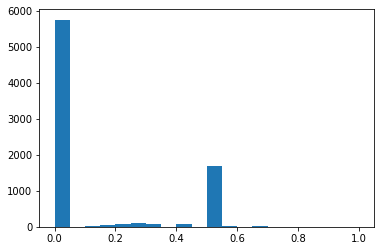

In [ ]:
error_distribution(df_test, "berttiny")

###### DistilRoBERTa without history

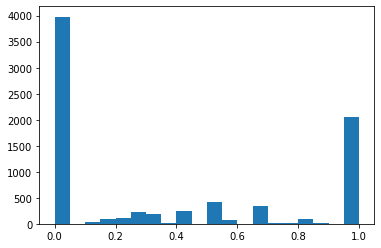

In [ ]:
error_distribution(df_test, "roberta")

###### BERTTiny with history

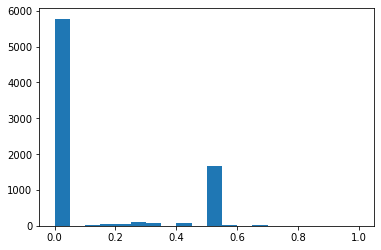

In [ ]:
error_distribution(his_df_test, "berttiny")

###### DistilRoBERTa with history

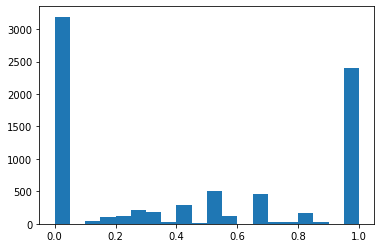

In [ ]:
error_distribution(his_df_test, "roberta")

### Sources Analysis

Display the five worst questions (featuring the highest number of errors) for each source, and the corresponding F1 score. The average F1 score for each source is also computed and printed, so as to find out whether any source contains questions that are easier to answer.

We can say that there is no source that is easier to answer than others, indeed, in all four models, the average F1 scores from all sources are very similar.

Furthermore, we can observe that _fluent_ is the most frequent question type in the five worst answer for each source and for each model.

In [ ]:
def worst_five_by_source(df_test, model_name):
  print("### SOURCES ###\n")
  print("CNN")
  print(df_test[df_test["source"] == "cnn"].sort_values(by = f"f1_{model_name}", axis = 0)[["question", "answer", f"gen_{model_name}", f"f1_{model_name}", "qa_type"]][:5])
  print("\nWikipedia")
  print(df_test[df_test["source"] == "wikipedia"].sort_values(by = f"f1_{model_name}", axis = 0)[["question", "answer", f"gen_{model_name}", f"f1_{model_name}", "qa_type"]][:5])
  print("\nRace")
  print(df_test[df_test["source"] == "race"].sort_values(by = f"f1_{model_name}", axis = 0)[["question", "answer", f"gen_{model_name}", f"f1_{model_name}", "qa_type"]][:5])
  print("\nGutenberg")
  print(df_test[df_test["source"] == "gutenberg"].sort_values(by = f"f1_{model_name}", axis = 0)[["question", "answer", f"gen_{model_name}", f"f1_{model_name}", "qa_type"]][:5])
  print("\nMCTest")
  print(df_test[df_test["source"] == "mctest"].sort_values(by = f"f1_{model_name}", axis = 0)[["question", "answer", f"gen_{model_name}", f"f1_{model_name}", "qa_type"]][:5])

In [ ]:
def f1_per_source(df_test, model_name):
  print("### SOURCES ###\n")
  print("CNN")
  print("f1 =", np.mean(df_test[df_test["source"] == "cnn"][f"f1_{model_name}"]))
  print("\nWikipedia")
  print("f1 =", np.mean(df_test[df_test["source"] == "wikipedia"][f"f1_{model_name}"]))
  print("\nRace")
  print("f1 =", np.mean(df_test[df_test["source"] == "race"][f"f1_{model_name}"]))
  print("\nGutenberg")
  print("f1 =", np.mean(df_test[df_test["source"] == "gutenberg"][f"f1_{model_name}"]))
  print("\nMCTest")
  print("f1 =", np.mean(df_test[df_test["source"] == "mctest"][f"f1_{model_name}"]))

###### BERTTiny without history

In [ ]:
worst_five_by_source(df_test, "berttiny")

### SOURCES ###

CNN
                                          question  \
4104        what does john howard think of abbott?   
4974                       what was his character?   
4973                         who got the 2008 one?   
4972  what the real life charactere present there?   
4971             what sports was in the storyline?   

                                                 answer  \
4104  understood that you could make a new friend wi...   
4974                                       harvey milk.   
4973                                         sean penn.   
4972                                               yes.   
4971                                          football.   

                        gen_berttiny  f1_berttiny qa_type  
4104  it's official official website          0.0  fluent  
4974            his mother's mother.          0.0  fluent  
4973          his father a young man          0.0  fluent  
4972            her mother's mother.          0.0     yes  

In [ ]:
f1_per_source(df_test, "berttiny")

### SOURCES ###

CNN
f1 = 0.10979147671314134

Wikipedia
f1 = 0.10316888359808263

Race
f1 = 0.13711755718750393

Gutenberg
f1 = 0.1436215855415607

MCTest
f1 = 0.1363219389646451


###### DistilRoBERTa without history

In [ ]:
worst_five_by_source(df_test, "roberta")

### SOURCES ###

CNN
                                               question  \
4104             what does john howard think of abbott?   
5993                                  what is his name?   
2995                what kind of reputation has gotten?   
5992                                  who was involved?   
5701  how soon after his injury bauman started helpi...   

                                                 answer          gen_roberta  \
4104  understood that you could make a new friend wi...  he's a rock rocker.   
5993                                         nick hogan       nicklele bolle   
2995                           out-of-control celebrity    an out of control   
5992                                  son of hulk hogan       hannah hallele   
5701                                        a day after        two weeks ago   

      f1_roberta qa_type  
4104         0.0  fluent  
5993         0.0  fluent  
2995         0.0  fluent  
5992         0.0  fluent  
5701    

In [ ]:
f1_per_source(df_test, "roberta")

### SOURCES ###

CNN
f1 = 0.36643907755199917

Wikipedia
f1 = 0.33588718425848224

Race
f1 = 0.38605182018056067

Gutenberg
f1 = 0.33041330205281494

MCTest
f1 = 0.42441072391016416


###### BERTTiny with history

In [ ]:
worst_five_by_source(his_df_test, "berttiny")

### SOURCES ###

CNN
                                          question  \
4104        what does john howard think of abbott?   
4975        what was the man's sexual orientation?   
4974                       what was his character?   
4973                         who got the 2008 one?   
4972  what the real life charactere present there?   

                                                 answer  \
4104  understood that you could make a new friend wi...   
4975                                               gay.   
4974                                       harvey milk.   
4973                                         sean penn.   
4972                                               yes.   

                  gen_berttiny  f1_berttiny qa_type  
4104              cnn cnn cnn.          0.0  fluent  
4975  his father died he was a          0.0  fluent  
4974     his father's mother's          0.0  fluent  
4973       his mother's mother          0.0  fluent  
4972     her mother's mother'

In [ ]:
f1_per_source(his_df_test, "berttiny")

### SOURCES ###

CNN
f1 = 0.10963800009248698

Wikipedia
f1 = 0.10137158172539922

Race
f1 = 0.13592565096221404

Gutenberg
f1 = 0.1421477956837758

MCTest
f1 = 0.13742098868948766


###### DistilRoBERTa with history

In [ ]:
worst_five_by_source(his_df_test, "roberta")

### SOURCES ###

CNN
                                               question  \
4104             what does john howard think of abbott?   
2460                          who doe he claim gave it?   
5108                               where is sandy hook?   
2462                                               who?   
5103  true or false: that day will be the first time...   

                                                 answer  \
4104  understood that you could make a new friend wi...   
2460                            michael jackson himself   
5108                               newtown, connecticut   
2462                          one of michael's sisters,   
5103                                               true   

                                     gen_roberta  f1_roberta   qa_type  
4104                he was a rock rock rock star         0.0    fluent  
2460                                the doctor's         0.0    fluent  
5108  in elementary elementary elementary school  

In [ ]:
f1_per_source(his_df_test, "roberta")

### SOURCES ###

CNN
f1 = 0.44923067408667516

Wikipedia
f1 = 0.4360385423084686

Race
f1 = 0.4509504120227869

Gutenberg
f1 = 0.40827678450014604

MCTest
f1 = 0.4895296254455563


### QA Type Analysis

Finally, the average F1 score per question type is computed in order to confirm or reject our hypothesis. The results show that the easiest question type to answer is _yes_, medium difficulty questions are _no_, _count_ and _multiple_, and the hardest type of questions turns out to be _fluent_. 

In [ ]:
def f1_per_qa_type(df_test, model_name):
  print("### QA TYPES ###\n")
  print("Yes")
  print("f1 =", np.mean(df_test[df_test["qa_type"] == "yes"][f"f1_{model_name}"]))
  print("\nNo")
  print("f1 =", np.mean(df_test[df_test["qa_type"] == "no"][f"f1_{model_name}"]))
  print("\nCount")
  print("f1 =", np.mean(df_test[df_test["qa_type"] == "count"][f"f1_{model_name}"]))
  print("\nMultiple")
  print("f1 =", np.mean(df_test[df_test["qa_type"] == "multiple"][f"f1_{model_name}"]))
  print("\nFluent")
  print("f1 =", np.mean(df_test[df_test["qa_type"] == "fluent"][f"f1_{model_name}"]))
  

###### BERTTiny without history

In [ ]:
f1_per_qa_type(df_test, "berttiny")

### QA TYPES ###

Yes
f1 = 0.48683314415437

No
f1 = 0.487744261051034

Count
f1 = 0.138993899389939

Multiple
f1 = 0.00684931506849315

Fluent
f1 = 0.02654249246110127


###### DistilRoBERTa without history

In [ ]:
f1_per_qa_type(df_test, "roberta")

### QA TYPES ###

Yes
f1 = 0.6952602070649744

No
f1 = 0.6325345084309227

Count
f1 = 0.5102388810309602

Multiple
f1 = 0.2602739726027397

Fluent
f1 = 0.2786231073961798


###### BERTTiny with history

In [ ]:
f1_per_qa_type(his_df_test, "berttiny")

### QA TYPES ###

Yes
f1 = 0.4881195611048051

No
f1 = 0.4840700689306267

Count
f1 = 0.12722272227222722

Multiple
f1 = 0.00684931506849315

Fluent
f1 = 0.026420882520024485


###### DistilRoBERTa with history

In [ ]:
f1_per_qa_type(his_df_test, "roberta")

### QA TYPES ###

Yes
f1 = 0.7817046744402023

No
f1 = 0.5427191666235491

Count
f1 = 0.5693357430981194

Multiple
f1 = 0.41050228310502285

Fluent
f1 = 0.3774285774323169


### Answer Generation

In this paragraph we show an example of answer generation. In the first case the story does not contain the history of the conversation, whereas in the second case the story contains also the history conversation.

It turns out that in BERTTiny models the presence of the conversational history does not significantly influence the generated answer, whereas in DistilRoBERTa models it improves the generated answer.

###### BERTTiny without history

In [ ]:
print(df_test["story"][83])
print("\n\nQuestion:", df_test["question"][83])
print("\nAnswer:", generate(df_test["story"][83], df_test["question"][83], berttiny_model, berttiny_tokenizer))
print("\nCorrect Answer:", df_test["answer"][83])

staten island is one of the five boroughs of new york city in the u.s. state of new york. in the southwest of the city, staten island is the southernmost part of both the city and state of new york, with conference house park at the southern tip of the island and the state. the borough is separated from new jersey by the arthur kill and the kill van kull, and from the rest of new york by new york bay. with a 2016 census-estimated population of 476,015, staten island is the least populated of the boroughs but is the third-largest in area at . staten island is the only borough of new york with a non-hispanic white majority. the borough is coextensive with richmond county, and until 1975 was the borough of richmond. its flag was later changed to reflect this. staten island has been sometimes called "the forgotten borough" by inhabitants who feel neglected by the city government. 

the north shore—especially the neighborhoods of st. george, tompkinsville, clifton, and stapleton—is the most

###### BERTTiny with history

In [ ]:
print(his_df_test["story"][83])
print("\n\nQuestion:", his_df_test["question"][83])
print("\nAnswer:", generate(his_df_test["story"][83], his_df_test["question"][83], his_berttiny_model, his_berttiny_tokenizer))
print("\nCorrect Answer:", his_df_test["answer"][83])

staten island is one of the five boroughs of new york city in the u.s. state of new york. in the southwest of the city, staten island is the southernmost part of both the city and state of new york, with conference house park at the southern tip of the island and the state. the borough is separated from new jersey by the arthur kill and the kill van kull, and from the rest of new york by new york bay. with a 2016 census-estimated population of 476,015, staten island is the least populated of the boroughs but is the third-largest in area at . staten island is the only borough of new york with a non-hispanic white majority. the borough is coextensive with richmond county, and until 1975 was the borough of richmond. its flag was later changed to reflect this. staten island has been sometimes called "the forgotten borough" by inhabitants who feel neglected by the city government. 

the north shore—especially the neighborhoods of st. george, tompkinsville, clifton, and stapleton—is the most

###### DistilRoBERTa without history

In [ ]:
print(df_test["story"][83])
print("\n\nQuestion:", df_test["question"][83])
print("\nAnswer:", generate(df_test["story"][83], df_test["question"][83], roberta_model, roberta_tokenizer))
print("\nCorrect Answer:", df_test["answer"][83])

staten island is one of the five boroughs of new york city in the u.s. state of new york. in the southwest of the city, staten island is the southernmost part of both the city and state of new york, with conference house park at the southern tip of the island and the state. the borough is separated from new jersey by the arthur kill and the kill van kull, and from the rest of new york by new york bay. with a 2016 census-estimated population of 476,015, staten island is the least populated of the boroughs but is the third-largest in area at . staten island is the only borough of new york with a non-hispanic white majority. the borough is coextensive with richmond county, and until 1975 was the borough of richmond. its flag was later changed to reflect this. staten island has been sometimes called "the forgotten borough" by inhabitants who feel neglected by the city government. 

the north shore—especially the neighborhoods of st. george, tompkinsville, clifton, and stapleton—is the most

###### DistilRoBERTa with history

In [ ]:
print(his_df_test["story"][83])
print("\n\nQuestion:", his_df_test["question"][83])
print("\nAnswer:", generate(his_df_test["story"][83], his_df_test["question"][83], his_roberta_model, his_roberta_tokenizer))
print("\nCorrect Answer:", his_df_test["answer"][83])

staten island is one of the five boroughs of new york city in the u.s. state of new york. in the southwest of the city, staten island is the southernmost part of both the city and state of new york, with conference house park at the southern tip of the island and the state. the borough is separated from new jersey by the arthur kill and the kill van kull, and from the rest of new york by new york bay. with a 2016 census-estimated population of 476,015, staten island is the least populated of the boroughs but is the third-largest in area at . staten island is the only borough of new york with a non-hispanic white majority. the borough is coextensive with richmond county, and until 1975 was the borough of richmond. its flag was later changed to reflect this. staten island has been sometimes called "the forgotten borough" by inhabitants who feel neglected by the city government. 

the north shore—especially the neighborhoods of st. george, tompkinsville, clifton, and stapleton—is the most